In [177]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import sklearn
from plotly.subplots import make_subplots
import plotly.express as px

In [178]:
df_2002=pd.read_csv("../efa_csv/2002.csv")
df_2012=pd.read_csv("../efa_csv/2012.csv")
df_2022=pd.read_csv("../efa_csv/2022.csv")

/var/folders/7h/y6lh43p93vl_bgy8rc2z416c0000gn/T/ipykernel_49178/568141019.py:2: DtypeWarning:

Columns (9,39) have mixed types. Specify dtype option on import or set low_memory=False.



In [179]:
df_2002=df_2002[df_2002['age']>=18]
df_2012=df_2012[df_2012['age']>=18]
df_2022=df_2022[df_2022['age']>=18]
df_2002=df_2002[df_2002['marital']=='Married']
df_2012=df_2012[df_2012['marital']=='Married']
df_2022=df_2022[df_2022['marital']=='Married']

In [180]:
gender_color_map = {"Female":"#f678a7", "Male": "#add2e4"}

In [181]:
## Mapping questions and variable names
v_map_2002={
    'v4_egal': 'item1',
    'v5_egal': 'item2',
    'v6_egal': 'item3',
    'v7_egal': 'item4',
    'v8_egal': 'item5',
    'v11_egal': 'item6',
}
v_map_2012={
    'V5_egal': 'item1',
    'V6_egal': 'item2',
    'V7_egal': 'item3',
    'V8_egal': 'item4',
    'V9_egal': 'item5',
    'V11_egal': 'item6',
}
v_map_2022 = {
    'v1_egal': 'item1',
    'v2_egal': 'item2',
    'v3_egal': 'item3',
    'v4_egal': 'item4',
    'v5_egal': 'item5',
    'v6_egal': 'item6',
}

Combined explained variance (%): [45.57 18.17 11.34 10.74  7.97  6.21]


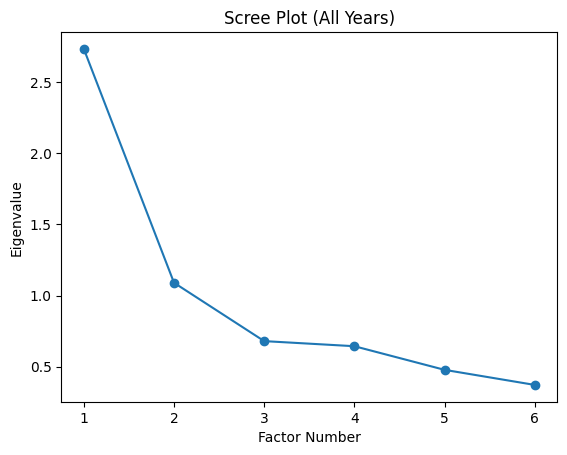

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

a_items = ['item1', 'item2', 'item3', 'item4', 'item5', 'item6']

pca_2002 = df_2002[v_map_2002.keys()].rename(columns=v_map_2002).assign(year=2002)
pca_2012 = df_2012[v_map_2012.keys()].rename(columns=v_map_2012).assign(year=2012)
pca_2022 = df_2022[v_map_2022.keys()].rename(columns=v_map_2022).assign(year=2022)

combined_pca = pd.concat([pca_2002, pca_2012, pca_2022], axis=0, ignore_index=True)
combined_pca = combined_pca.dropna(subset=a_items)

X = combined_pca[a_items].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca.fit(X_scaled)

eigenvalues = pca.explained_variance_
explained_pct = pca.explained_variance_ratio_ * 100
print('Combined explained variance:', np.round(explained_pct, 2))

plt.figure()
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.xlabel('Factor Number')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot (All Years)')
plt.show()

In [183]:
import numpy as np
import pandas as pd
from typing import Optional, List, Dict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

def make_dfs(df, item_cols):
    X = df[item_cols].copy()
    
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")

    X = X.dropna(axis=0)    
    return X


def factor_analysis_prechecks(X):
    chi2, p = calculate_bartlett_sphericity(X.values)
    kmo_all, kmo_model = calculate_kmo(X.values)
    return {
        "bartlett_chi2": chi2,
        "bartlett_p": p,
        "kmo_model": float(kmo_model),
        "kmo_item_mean": float(np.mean(kmo_all)),
    }


def factor_analysis(X,n_factors,rotation: Optional[str] = None,method: str = "principal",standardize: bool = True,):
    """
    Returns loadings, factor scores, and variance explained
    """
    X_in = X.copy()

    if standardize:
        scaler = StandardScaler()
        Z = scaler.fit_transform(X_in)
        Z = pd.DataFrame(Z, columns=X_in.columns, index=X_in.index)
    else:
        Z = X_in

    fa = FactorAnalyzer(n_factors=n_factors, rotation=rotation, method=method)
    fa.fit(Z.values)
    weights = fa.transform(X)
    print(weights)
    # Loadings
    loadings = pd.DataFrame(
        fa.loadings_,
        index=Z.columns,
        columns=[f"F{i+1}" for i in range(n_factors)]
    )

    # Communalities + uniqueness
    communalities = pd.Series(fa.get_communalities(), index=Z.columns, name="communality")
    uniqueness = pd.Series(fa.get_uniquenesses(), index=Z.columns, name="uniqueness")

    # Variance explained
    var, prop_var, cum_var = fa.get_factor_variance()
    variance_explained = pd.DataFrame(
        {
            "variance": var,
            "prop_variance": prop_var,
            "cum_prop_variance": cum_var,
        },
        index=[f"F{i+1}" for i in range(n_factors)]
    )

    # Factor scores
    scores = fa.transform(Z.values)
    factor_scores = pd.DataFrame(
        scores,
        index=Z.index,
        columns=[f"F{i+1}_score" for i in range(n_factors)]
    )

    return {
        "Z": Z,
        "fa": fa,
        "loadings": loadings,
        "communalities": communalities,
        "uniqueness": uniqueness,
        "variance_explained": variance_explained,
        "factor_scores": factor_scores,
    }


def cronbach_alpha(X):
    """
    Cronbach's alpha for reliability
    """
    Xv = X.values
    item_vars = Xv.var(axis=0, ddof=1)
    total_var = Xv.sum(axis=1).var(ddof=1)
    k = X.shape[1]
    if k < 2 or total_var == 0:
        return np.nan
    return float((k / (k - 1)) * (1 - item_vars.sum() / total_var))

In [184]:
def do_factor_analysis(df,item_cols,n_factors=2, rotation=None, method="principal", standardize=True):
    X=make_dfs(df,item_cols)
    precheck=factor_analysis_prechecks(X)

    print(f"  Bartlett's χ²: {precheck['bartlett_chi2']:.2f}, p-value: {precheck['bartlett_p']:.4f}")
    print(f"  KMO: {precheck['kmo_model']:.4f}")

    if precheck['bartlett_p']>0.05:
        print("Data not suitable for Factor Analysis")
        return
    
    print("Factor Analysis can be conducted")
    fa=factor_analysis(X, n_factors, rotation, method, standardize)
    print("Variance Explained:")
    print(fa["variance_explained"])
    print("\nFactor Loadings (sorted by magnitude):")
    print(fa["loadings"].sort_values("F1", key=lambda s: s.abs(), ascending=False))
    print("\nCommunalities")
    print(fa['communalities'])

    alpha_2022 = cronbach_alpha(fa["Z"])
    print(f"Cronbach's Alpha: {alpha_2022:.3f}")
    
    df=df.join(fa["factor_scores"], how="left")
    return df,fa

    

In [185]:
df_2002_f1,fa_2002=do_factor_analysis(df_2002,item_cols=[v for v in v_map_2002.keys()])

  Bartlett's χ²: 27942.63, p-value: 0.0000
  KMO: 0.7630
Factor Analysis can be conducted
[[ 6.82228601e+00 -2.26173979e-01]
 [ 1.95421285e+00  3.98065148e-03]
 [ 6.18314747e+00 -1.15212190e+00]
 ...
 [ 3.96650604e+00 -1.22074387e+00]
 [ 3.15910592e+00  8.81854964e-01]
 [ 4.24099561e+00 -9.93767520e-01]]
Variance Explained:
    variance  prop_variance  cum_prop_variance
F1  2.607528       0.434588           0.434588
F2  1.106219       0.184370           0.618958

Factor Loadings (sorted by magnitude):
                F1        F2
v5_egal   0.759482 -0.304265
v6_egal   0.757745 -0.306043
v11_egal  0.715739  0.251085
v7_egal   0.682022  0.373565
v4_egal   0.522121 -0.524338
v8_egal   0.454413  0.665172

Communalities
v4_egal     0.547540
v5_egal     0.669390
v6_egal     0.667840
v7_egal     0.604705
v8_egal     0.648945
v11_egal    0.575327
Name: communality, dtype: float64
Cronbach's Alpha: 0.729


/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

divide by zero encountered in matmul

/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

overflow encountered in matmul

/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

invalid value encountered in matmul

/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib/python3.9/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

divide by zero encountered in matmul

/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib

In [186]:
df_2012_f1,fa_2012=do_factor_analysis(df_2012,item_cols=[v for v in v_map_2012.keys()])

  Bartlett's χ²: 36846.87, p-value: 0.0000
  KMO: 0.7692
Factor Analysis can be conducted


/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

divide by zero encountered in matmul

/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

overflow encountered in matmul

/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

invalid value encountered in matmul

/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib/python3.9/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

divide by zero encountered in matmul

/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib

[[ 3.86085465  1.74683322]
 [ 3.69091083  0.2070581 ]
 [ 3.33309707 -0.980427  ]
 ...
 [ 6.33042846 -1.95958064]
 [ 3.29322574  1.870223  ]
 [ 3.75988225  1.06372877]]
Variance Explained:
    variance  prop_variance  cum_prop_variance
F1  2.643713       0.440619           0.440619
F2  1.086718       0.181120           0.621738

Factor Loadings (sorted by magnitude):
                F1        F2
V6_egal   0.771719 -0.258530
V7_egal   0.761998 -0.268498
V11_egal  0.711590  0.225375
V8_egal   0.703972  0.336280
V5_egal   0.491809 -0.606291
V9_egal   0.472978  0.645231

Communalities
V5_egal     0.609465
V6_egal     0.662387
V7_egal     0.652732
V8_egal     0.608661
V9_egal     0.640031
V11_egal    0.557155
Name: communality, dtype: float64
Cronbach's Alpha: 0.734


/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [187]:
df_2022_f1,fa_2022=do_factor_analysis(df_2022,item_cols=[v for v in v_map_2022.keys()])

  Bartlett's χ²: 34009.24, p-value: 0.0000
  KMO: 0.7859
Factor Analysis can be conducted


/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



[[ 1.9611794  -0.36926181]
 [ 6.81626371  0.87543422]
 [ 3.50163484 -1.26296617]
 ...
 [ 5.19601659  1.43690367]
 [ 2.87945909  0.80584903]
 [ 5.66898073  0.49292537]]
Variance Explained:
    variance  prop_variance  cum_prop_variance
F1  2.867921       0.477987           0.477987
F2  1.104051       0.184008           0.661995

Factor Loadings (sorted by magnitude):
               F1        F2
v2_egal  0.785730 -0.257482
v6_egal  0.776545  0.211283
v3_egal  0.774230 -0.286256
v4_egal  0.757421  0.310114
v1_egal  0.526270 -0.554229
v5_egal  0.444351  0.712622

Communalities
v1_egal    0.584129
v2_egal    0.683669
v3_egal    0.681375
v4_egal    0.669857
v5_egal    0.705279
v6_egal    0.647663
Name: communality, dtype: float64
Cronbach's Alpha: 0.768


/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

divide by zero encountered in matmul

/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

overflow encountered in matmul

/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

invalid value encountered in matmul

/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib/python3.9/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

divide by zero encountered in matmul

/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib/python3.9/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

overflow encountered in matmul

/Users/rashikakukreja/Masters/Data Literacy/Project/ML4102/.env/lib/python3.9/site-packages/sklearn/utils/extmath.py:336: Runtim

In [188]:
def min_max_normalize(series):
    min_val = series.min()
    max_val = series.max()
    if max_val == min_val:
        return pd.Series(0, index=series.index)
    return (series - min_val) / (max_val - min_val)

df_2002_f1['F1_score_norm'] = min_max_normalize(df_2002_f1['F1_score'])
df_2012_f1['F1_score_norm'] = min_max_normalize(df_2012_f1['F1_score'])
df_2022_f1['F1_score_norm'] = min_max_normalize(df_2022_f1['F1_score'])

df_2002_f1['F2_score_norm'] = min_max_normalize(df_2002_f1['F2_score'])
df_2012_f1['F2_score_norm'] = min_max_normalize(df_2012_f1['F2_score'])
df_2022_f1['F2_score_norm'] = min_max_normalize(df_2022_f1['F2_score'])
    

In [189]:
df_2002_f1.rename(columns={'F1_score_norm': 'eg_score_norm'}, inplace=True)
df_2012_f1.rename(columns={'F1_score_norm': 'eg_score_norm'}, inplace=True)
df_2022_f1.rename(columns={'F1_score_norm': 'eg_score_norm'}, inplace=True)
df_2002_f1.rename(columns={'F1_score': 'eg_score'}, inplace=True)
df_2012_f1.rename(columns={'F1_score': 'eg_score'}, inplace=True)
df_2022_f1.rename(columns={'F1_score': 'eg_score'}, inplace=True)


In [190]:
df_2002_f1.to_csv("../efa_csv/2002.csv", index=False)
df_2012_f1.to_csv("../efa_csv/2012.csv", index=False)
df_2022_f1.to_csv("../efa_csv/2022.csv", index=False)

In [191]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("2002", "2012", "2022"))

for idx, (data, year) in enumerate([(df_2002_f1, "2002"), (df_2012_f1, "2012"), (df_2022_f1, "2022")], start=1):
    clean = data.dropna(subset=["eg_score_norm", "sex"])
    
    for gender in ['Female', 'Male']:
        subset = clean[clean['sex'] == gender]
        if subset.empty:
            continue
        fig.add_trace(
            go.Box(
                y=subset['eg_score_norm'],
                name=gender,
                marker_color=gender_color_map[gender],
                boxmean=True,
                showlegend=(idx == 1)
            ),
            row=1, col=idx
        )

fig.update_layout(
    height=600, width=1800,
    boxmode='group',
    title="Normalized F1 Score Distribution by Gender",
    legend_title_text='Gender'
)
fig.update_yaxes(title_text="Normalized Equality Score (0-1)", range=[0, 1])
fig.show()

In [192]:
loadings_22=pd.DataFrame(fa_2022['loadings'])
loadings_12=pd.DataFrame(fa_2012['loadings'])
loadings_02=pd.DataFrame(fa_2002['loadings'])

In [ ]:
def plot_loadings(loadings, cutoff=0.3):
    import numpy as np
    import plotly.express as px

    loadings_plot = loadings.reset_index().rename(columns={"index": "item"})

    loadings_plot["dominant_factor"] = np.where(
        loadings_plot["F1"].abs() >= loadings_plot["F2"].abs(),
        "Factor 1",
        "Factor 2"
    )

    fig = px.scatter(
        loadings_plot,
        x="F1",
        y="F2",
        color="dominant_factor",
        text="item",
        title="Factor Pattern Plot",
        labels={"F1": "Factor 1", "F2": "Factor 2"},
        color_discrete_map={
            "Factor 1": "#1f77b4",
            "Factor 2": "#ff7f0e"
        }
    )

    fig.update_traces(textposition="top center", marker=dict(size=10))
    fig.add_hline(y=0, line_color="gray")
    fig.add_vline(x=0, line_color="gray")

    fig.update_layout(width=700, height=700)

    fig.show()


In [194]:
plot_loadings(loadings_22)

In [195]:
px.scatter(
    df_2022_f1,
    x="eg_score_norm",
    y="F2_score_norm",
    title="Individuals projected onto latent factor space (normalized)",
    labels={
        "eg_score_norm": "Factor 1 score",
        "F2_score_norm": "Factor 2 score"
    }
)


In [196]:
scores_df_22=df_2022_f1[['eg_score', 'F2_score']]
scores_df_12=df_2012_f1[['eg_score', 'F2_score']]
scores_df_02=df_2002_f1[['eg_score', 'F2_score']]

In [ ]:

def plot_loadings_scores(loadings_df, scores_df):

    scale = scores_df[["eg_score", "F2_score"]].std().mean()
    loadings_df_scaled = loadings_df.copy()
    loadings_df_scaled[["F1", "F2"]] *= scale

    import plotly.graph_objects as go

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=scores_df["eg_score"],
            y=scores_df["F2_score"],
            mode="markers",
            name="Individuals",
            marker=dict(size=4, opacity=0.5)
        )
    )
    for var, row in loadings_df_scaled.iterrows():
        fig.add_trace(
            go.Scatter(
                x=[0, row["F1"]],
                y=[0, row["F2"]],
                mode="lines+text",
                line=dict(width=2),
                text=[None, var],
                textposition="top center",
                showlegend=False
            )
        )
    fig.update_layout(
        title="Factor (Scores + Loadings)",
        xaxis_title="Factor 1",
        yaxis_title="Factor 2",
        xaxis=dict(zeroline=True),
        yaxis=dict(zeroline=True),
        template="plotly_white"
    )

    fig.show()


In [198]:
plot_loadings_scores(loadings_22,scores_df_22)

In [199]:
plot_loadings_scores(loadings_12,scores_df_12)

In [200]:
plot_loadings_scores(loadings_02,scores_df_02)

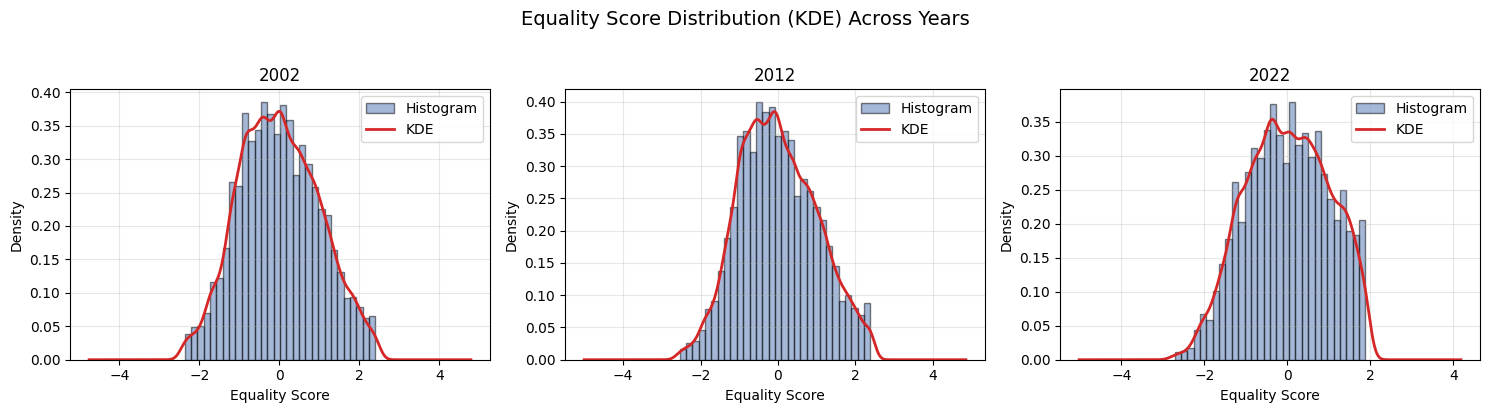

In [201]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Equality Score Distribution (KDE) Across Years', fontsize=14, y=1.02)

for idx, (data, year) in enumerate([(df_2002_f1, 2002), (df_2012_f1, 2012), (df_2022_f1, 2022)]):
    clean = data.dropna(subset=["eg_score"])
    
    axes[idx].hist(clean["eg_score"], bins=30, alpha=0.5, color='#4c72b0', edgecolor='black', density=True, label='Histogram')
    clean["eg_score"].plot(kind='kde', ax=axes[idx], color='#d62728', linewidth=2, label='KDE')
    axes[idx].set_title(f"{year}")
    axes[idx].set_xlabel("Equality Score")
    axes[idx].set_ylabel("Density")
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [202]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("2002", "2012", "2022"))

educ_order = ['No/Primary', 'Secondary', 'Post-sec / Short tertiary', 'University+']
educ_colors = {
    'No/Primary': '#4c78a8',
    'Secondary': '#f28e2b',
    'Post-sec / Short tertiary': '#59a14f',
    'University+': '#b07aa1'
}

for idx, (data, year) in enumerate([(df_2002_f1, "2002"), (df_2012_f1, "2012"), (df_2022_f1, "2022")], start=1):
    clean = data.dropna(subset=["eg_score_norm", "educ_4_label"]).copy()
    clean['educ_4_label'] = pd.Categorical(clean['educ_4_label'], categories=educ_order, ordered=True)
    
    avg_eg = clean.groupby('educ_4_label')['eg_score_norm'].mean().reindex(educ_order)
    
    fig.add_trace(
        go.Bar(
            x=avg_eg.index,
            y=avg_eg.values,
            marker_color=[educ_colors[level] for level in avg_eg.index],
            text=[f"{v:.3f}" for v in avg_eg.values],
            textposition="outside",
            showlegend=False
        ),
        row=1, col=idx
    )

fig.update_layout(
    height=600, width=2000,
    title="Mean Normalized Equality Score by Education Level",
    margin=dict(t=60, b=100)
)
fig.update_xaxes(title_text="Education Level", tickangle=40)
fig.update_yaxes(title_text="Mean Normalized Equality Score", range=[0, 1])
fig.show()

/var/folders/7h/y6lh43p93vl_bgy8rc2z416c0000gn/T/ipykernel_49178/2152129029.py:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/7h/y6lh43p93vl_bgy8rc2z416c0000gn/T/ipykernel_49178/2152129029.py:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/7h/y6lh43p93vl_bgy8rc2z416c0000gn/T/ipykernel_49178/2152129029.py:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

